*Quick note: make sure you have the following packages installed before using this notebook!*

In [27]:
#from astropy.stats import LombScargle # for periodograms
from astropy.timeseries import LombScargle
import corner # for visualizing parameter distributions
import numpy as np # for math and data storage
import pandas as pd # for math and data storage
import matplotlib.pyplot as plt # for plot making
import radvel # for fitting RVs
from radvel.plot import orbit_plots, mcmc_plots # for visualizing RVs
from scipy import optimize # for fitting RVs

# this bit below is just to fix an issue with radvel that appears if you're using numpy versions 1.22.0 or later!
try:
    np.__config__.blas_opt_info = np.__config__.blas_ilp64_opt_info
except Exception:
    pass

# Finding the Orbital Parameters of ???

Welcome to the Radial Velocities assignment! In this assignment, you're going to be finding the mass (or minimum mass) of a planet from radial velocity measurements from scratch, all on your own.

This is a very open-ended assignment, and I'd like you to code it all on your own! You pick the planet, you code it up. That said, I will give some steps (that you don't have to follow but may be helpful):

1. Figure out which planet you want to find the orbital parameters of! Not all RV data is good to work with, especially for people still getting used to RVs. Ideally, you find a planet that:
- is the only planet in its system (otherwise you'll have two signals! You can model them both if you want a challenge, but you don't need to here.)
- is a very massive planet! If you have Earthike planets, the signals start getting too small for RV methods to detect without also having to model things like stellar variability (and trust me -- as someone who struggles to do that as a job, it's tough!)
- Around a Sun-like star (really small stars have very high signal semi-amplitudes but have a lot of stellar variability, while really big stars have very small RV semi-amplitudes!
- Has RVs from only one instrument, as each instrument may have different offsets or quirks that make them more difficult to model together
- Has RVs you can easily download and access yourself!

  Here are a few papers containing RVs that satisfy those bullet points! You don't need to use them, but they're here if you'd rather not find a system yourself.
- TrES-2 b, with its paper [here](https://iopscience.iop.org/article/10.1086/509123/pdf)
- HAT-P-15 b, with its paper [here](https://iopscience.iop.org/article/10.1088/0004-637X/724/2/866)
- HD 22532 b, with its paper [here](https://www.aanda.org/articles/aa/full_html/2022/01/aa40078-20/aa40078-20.html)

2. Download and read in the data! In some papers (like the HAT-P-15 b paper or the HD 22532 paper), the RVs are available in a downloadable table in the paper. Sometimes, the data is linked through data centers like CDS, or maybe Simbad or Vizier; sometimes, like in the TrES-2 b paper, you just need to copy and paste the table into a .txt file :/ In any case, get the data and read it in. To make sure you know it works, maybe try plotting your RVs as a function of time, with error bars if you can!

3. Figure out your priors! Some of these are going to be informed by realistic numbers (e.g. informing that your jitter cannot be negative), while some of these are going to be informed by previous studies. For example, if the paper you're getting your RV data from notes that this planet is transiting, use priors informed by the transits for $P$ and $t_0$! (RVs can figure out those two values to the tune of hours or minutes, but transits can get so much more precise values for those -- down to a fraction of a second in some cases -- that it's worth just using the values of $P$ and $t_0$ from transit fits for your priors.)

4. Figure out what values to initialize your parameters to. It's okay to just do this by eye if you don't have better options, but if you have better options use them! For example, it might be worth making your own peridogram to figure out what value to initialize your planet's period to if you don't have transit data.

5. Run a simple optimization fit!

6. Do an MCMC fit.

7. Look at your results! Do they look reasonable? Are they consistent with the results found in the papers you got data from?

In [28]:
# TODO: find planet masses!

In [34]:
#!pip install numpy pandas matplotlib astropy corner radvel scipy

In [62]:
#!pip install seaborn

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi CSV dosyasından yükleyin
df = pd.read_csv("TrES_2_RV.csv")

In [57]:
df.head()

,Observation Epoch (HJD - 2400000),Radial Velocity (m/s),σRV (m/s)
0,53949.76054,135.5,6.1
1,53949.91993,96.8,6.1
2,53950.00216,58.9,7.7
3,53950.79018,201.0,8.1
4,53950.93491,204.8,9.0


In [58]:
df.shape

(11, 3)

In [63]:
df.isnull().sum()

Observation Epoch (HJD - 2400000)    0
Radial Velocity (m/s)                0
σRV (m/s)                            0
dtype: int64

<Axes: >

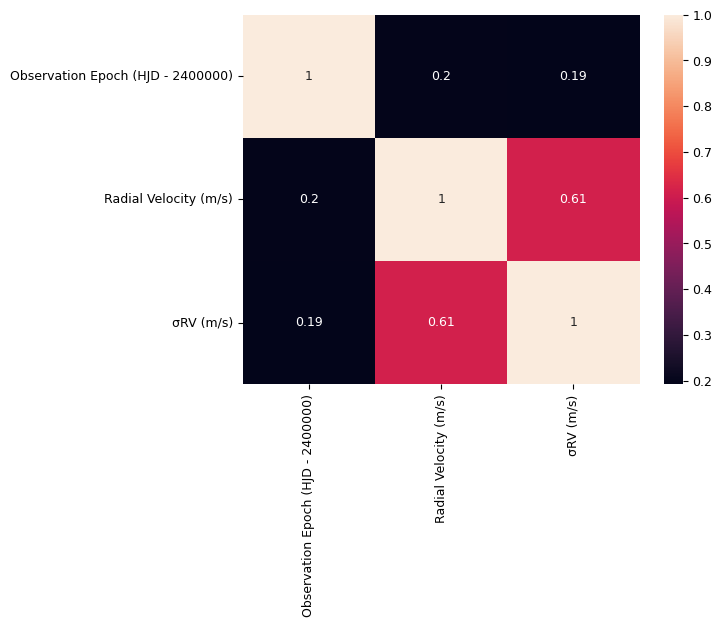

In [59]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Observation Epoch (HJD - 2400000),11.0,53950.998908,0.836222,53949.76054,53950.39617,53950.98051,53951.799475,53952.02736
Radial Velocity (m/s),11.0,146.518182,50.518231,58.90000,116.15000,140.50000,199.750000,204.80000
σRV (m/s),11.0,7.427273,1.110037,6.00000,6.55000,7.20000,8.250000,9.00000


2.Radial Velocity Verileri Grafik Üzerinde Gösterin

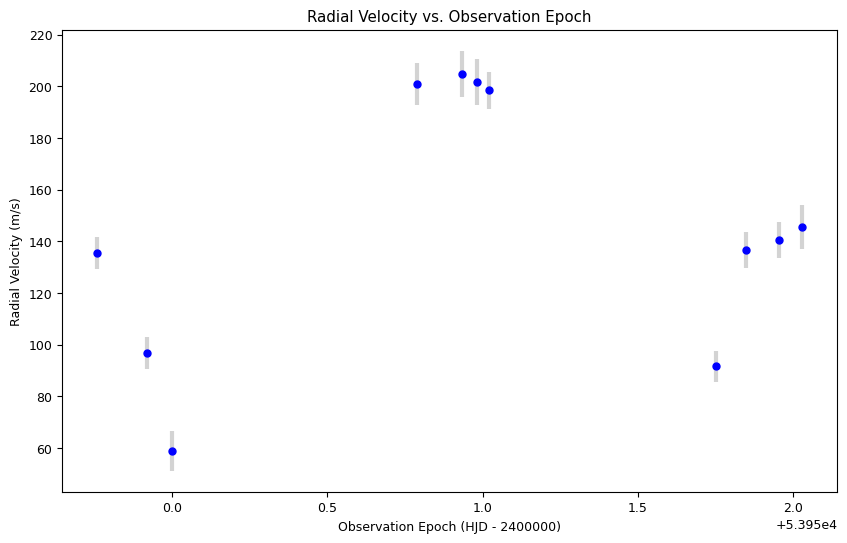

In [61]:
import matplotlib.pyplot as plt

# Veriyi grafik üzerinde gösterelim
plt.figure(figsize=(10, 6))
plt.errorbar(df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], yerr=df['σRV (m/s)'], fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
plt.xlabel('Observation Epoch (HJD - 2400000)')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocity vs. Observation Epoch')
plt.show()


3. Lomb-Scargle Periodogramı Hesaplama

In [66]:
#!pip install --upgrade astropy lightkurve

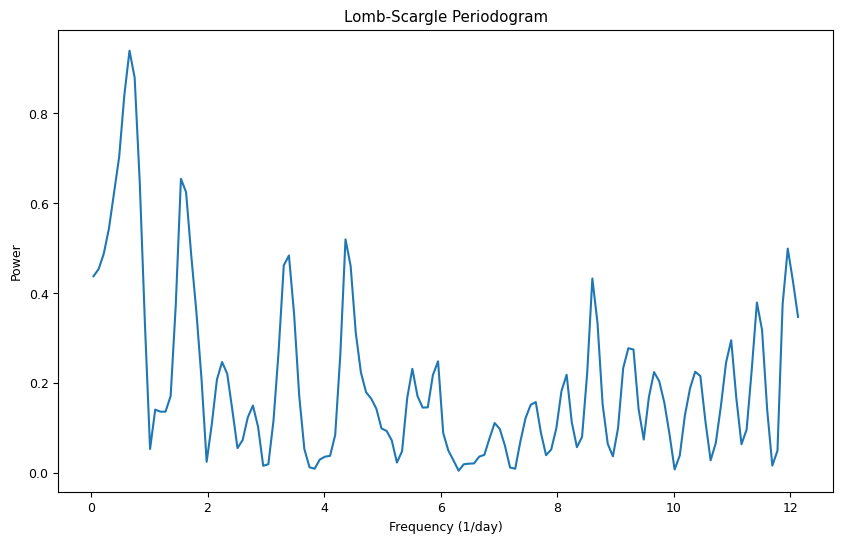

In [69]:
#from astropy.stats import LombScargle
from astropy.timeseries import LombScargle

# Lomb-Scargle periodogramı hesaplayalım
frequency, power = LombScargle(df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], df['σRV (m/s)']).autopower()

# Sonuçları görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(frequency, power)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()


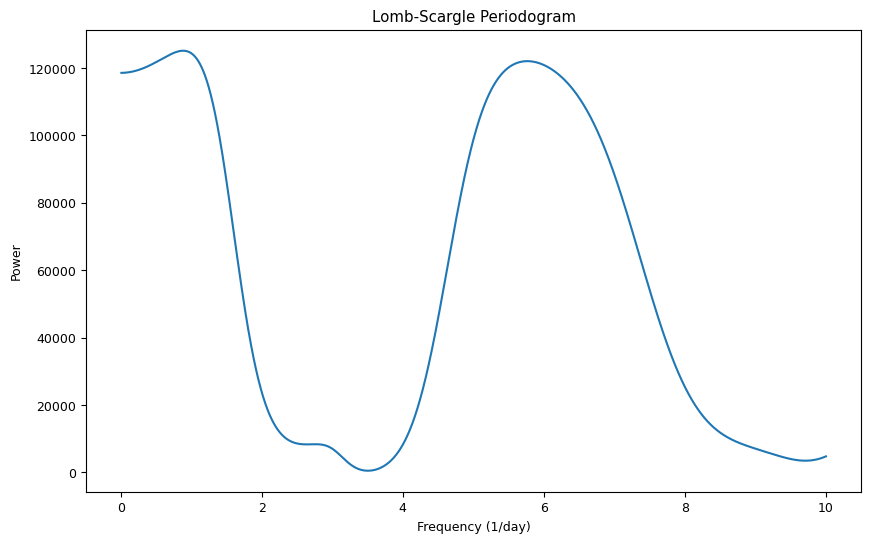

In [68]:
from scipy.signal import lombscargle

# Veri hazırlığı
x = df['Observation Epoch (HJD - 2400000)'].values
y = df['Radial Velocity (m/s)'].values
dy = df['σRV (m/s)'].values

# Frekans aralığı
frequencies = np.linspace(0.01, 10, 10000)

# Lomb-Scargle hesaplama
power = lombscargle(x, y, frequencies)

# Sonuçları görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()


5. Basit Optimizasyon Fit’i Yapma

In [74]:
# Optimizasyon parametre aralıkları belirleyerek
params, params_cov = optimize.curve_fit(
    model_rv, 
    df['Observation Epoch (HJD - 2400000)'], 
    df['Radial Velocity (m/s)'], 
    p0=[P_guess, K_guess, phi_guess, v0_guess], 
    maxfev=10000, 
    bounds=([0, 0, -np.pi, -100], [100, 200, np.pi, 100])  # Örnek aralıklar
)

P_fit, K_fit, phi_fit, v0_fit = params
print("Fitted parameters:", params)


Fitted parameters: [  2.47069092  53.92350491   3.14158795 100.        ]


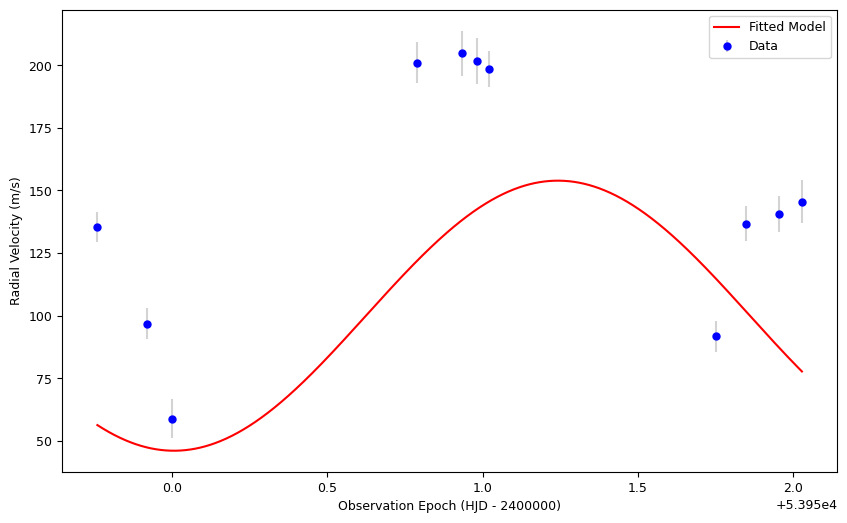

In [75]:
# Elde edilen parametreleri kullanarak radyal hız eğrisini hesaplayalım
t_fit = np.linspace(df['Observation Epoch (HJD - 2400000)'].min(), 
                    df['Observation Epoch (HJD - 2400000)'].max(), 1000)
rv_fit = model_rv(t_fit, P_fit, K_fit, phi_fit, v0_fit)

# Veri ve model sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))
plt.errorbar(df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], 
             yerr=df['σRV (m/s)'], fmt='o', label='Data', color='blue', ecolor='lightgray', capsize=0)
plt.plot(t_fit, rv_fit, label='Fitted Model', color='red')
plt.xlabel('Observation Epoch (HJD - 2400000)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.show()


6. MCMC Fit Yapma

100%|██████████| 5000/5000 [00:54<00:00, 91.46it/s] 


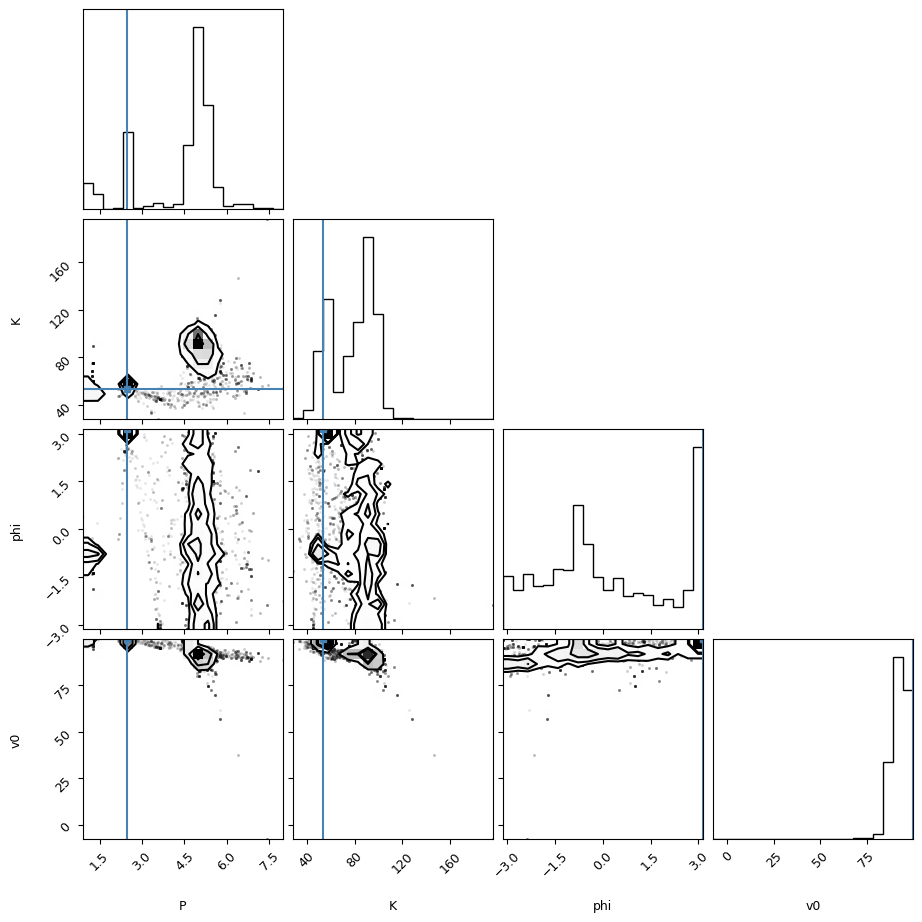

MCMC ile elde edilen parametreler:
P: 4.363052155846329
K: 77.91282740521261
phi: 0.10055147503921615
v0: 93.03714982685274


In [77]:
import emcee

# MCMC için log-olasılık fonksiyonu tanımlıyoruz
def log_likelihood(theta, t, rv, rv_err):
    P, K, phi, v0 = theta
    model = model_rv(t, P, K, phi, v0)
    sigma2 = rv_err ** 2
    return -0.5 * np.sum((rv - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_prior(theta):
    P, K, phi, v0 = theta
    if 0 < P < 100 and 0 < K < 200 and -np.pi < phi < np.pi and -100 < v0 < 100:
        return 0.0  # Uniform prior
    return -np.inf  # Diğer değerler için olasılık sıfır

def log_probability(theta, t, rv, rv_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, rv, rv_err)

# MCMC parametreleri
nwalkers = 32  # Walker sayısı
ndim = 4  # Parametre sayısı
nsteps = 5000  # Adım sayısı

# Başlangıç pozisyonları
initial = np.array([P_fit, K_fit, phi_fit, v0_fit])
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Sampler oluşturma
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], df['σRV (m/s)']))

# MCMC'yi çalıştırma
sampler.run_mcmc(pos, nsteps, progress=True)

# Sonuçları inceleme
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Parametrelerin köşe grafiğini çizme
fig = corner.corner(samples, labels=["P", "K", "phi", "v0"], truths=[P_fit, K_fit, phi_fit, v0_fit])
plt.show()

# Parametrelerin ortalamasını ve standart sapmasını hesaplama
P_mcmc, K_mcmc, phi_mcmc, v0_mcmc = np.mean(samples, axis=0)
print("MCMC ile elde edilen parametreler:")
print("P:", P_mcmc)
print("K:", K_mcmc)
print("phi:", phi_mcmc)
print("v0:", v0_mcmc)

# ChatGBT DEN yardım alındı.